# Compute Ratio VH/VV

Import python package :

In [1]:
import tarfile
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from pyproj import Proj, transform
try:
    import rasterio
except :
    !pip install rasterio
    import rasterio

     |████████████████████████████████| 19.1MB 13.5MB/s eta 0:00:01█████▋                     | 6.3MB 13.5MB/s eta 0:00:0101     | 12.5MB 13.5MB/s eta 0:00:01��██████████████████      | 15.6MB 13.5MB/s eta 0:00:015MB/s eta 0:00:01


### 1) Download product from s3

S3 access is available with maap-s3.py  
To have all options available, use the following command:

In [2]:
!maap-s3.py help

Usage: [option...] {upload|download|list|delete|refresh|resume}
upload     myFile.tiff locally          path/myFile.tiff in the S3    Upload data in the S3
download   myFileName.tiff              path/in/S3/file.tiff          Download a data from the S3
list       folder/path                                                List data in a subfolder
delete     path/in/S3/file.tiff                                       Delete an existing data on S3
refresh                                                               Refresh credentials and password
resume                                                                Resume last interrupted multipart upload


List of all Biosar1 products available from S3

In [7]:
!maap-s3.py list 'maap-scientific-data/edav_prepocessed_data/biosar1/'

[INFO]: Start finding data in path : maap-scientific-data/edav_prepocessed_data/biosar1/
[INFO] Get an existing or fresh token
[INFO] Personal user info is find
[INFO] Token is still valid
[INFO] Result list:
maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_HH_SCL_I_geo.tif
maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_HH_SCL_Q_geo.tif
maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_HH_amplitude_geo.tiff
maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_HV_SCL_I_geo.tif
maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_HV_SCL_Q_geo.tif
maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_HV_amplitude_geo.tiff
maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_VH_SCL_I_geo.tif
maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_VH_SCL_Q_geo.tif
maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_VH_amplitude_geo.tiff
maap-scientific-data

The download option allows you to get the product in an output directory.   
If the download fails, we try again after 5 seconds

In [13]:
if not os.path.exists('/projects/data'):
    os.mkdir('/projects/data')
    
if not os.path.exists('/projects/data/ratio'):
    os.mkdir('/projects/data/ratio')
    
while len(glob.glob('/projects/data/ratio/biosar1_105_SLC_VH_amplitude_geo.tiff')) == 0:
    !maap-s3.py download 'maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_VH_amplitude_geo.tiff' '/projects/data/ratio/biosar1_105_SLC_VH_amplitude_geo.tiff'
    time.sleep(5)
    
while len(glob.glob('/projects/data/ratio/biosar1_105_SLC_VV_amplitude_geo.tiff')) == 0:
    !maap-s3.py download 'maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_VV_amplitude_geo.tiff' '/projects/data/ratio/biosar1_105_SLC_VV_amplitude_geo.tiff'
    time.sleep(5)

[INFO] path file is :  maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_VH_amplitude_geo.tiff
[INFO] Get an existing or fresh token
[INFO] Personal user info is find
[INFO] Token is still valid
[INFO] we are about to download the data
[INFO] Download finished
[INFO] path file is :  maap-scientific-data/edav_prepocessed_data/biosar1/biosar1_105_SLC_VV_amplitude_geo.tiff
[INFO] Get an existing or fresh token
[INFO] Personal user info is find
[INFO] Token is still valid
[INFO] we are about to download the data
[INFO] Download finished


### 2) Compute Ratio 

In [14]:
vh_file = glob.glob('/projects/data/ratio/*VH*.tiff')[0]
vv_file = glob.glob('/projects/data/ratio/*VV*.tiff')[0]

In [15]:
vh_arr = rasterio.open(vh_file).read(1)
vv_arr = rasterio.open(vv_file).read(1)

vh_arr[vh_arr == -9999.0] = np.nan
vv_arr[vv_arr == -9999.0] = np.nan

print(np.nanmin(vh_arr), np.nanmax(vh_arr))
print(np.nanmean(vh_arr), np.nanmedian(vh_arr))

3.833723e-07 3.998615
0.17904876 0.13451308


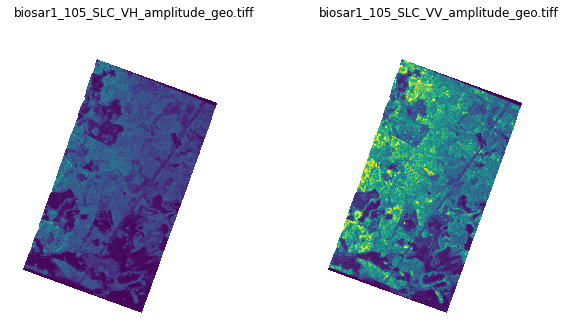

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,10))
ax1.imshow(vh_arr , vmin = 0, vmax = 1)
ax1.axis(False)
ax1.set_title('biosar1_105_SLC_VH_amplitude_geo.tiff')
ax2.imshow(vv_arr , vmin = 0, vmax = 1)
ax2.axis(False)
ax2.set_title('biosar1_105_SLC_VV_amplitude_geo.tiff')
print()

0.0001753432 3848.283
0.70687824 0.42620754


Text(0.5, 1.0, 'ratio VH/VV')

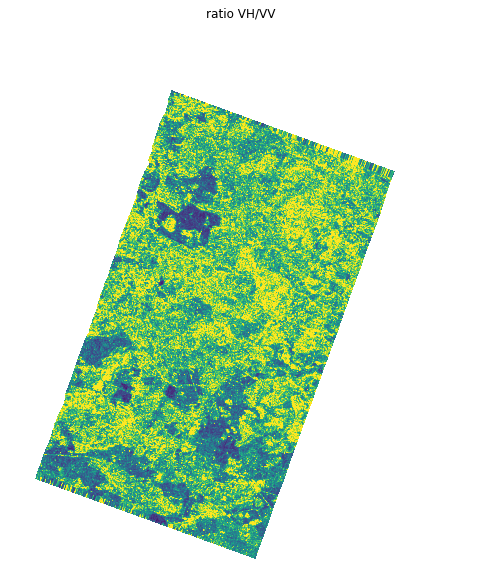

In [17]:
ratio = vh_arr / vv_arr
print(np.nanmin(ratio), np.nanmax(ratio))
print(np.nanmean(ratio), np.nanmedian(ratio))
np.save('/projects/data/ratio/ratio.npy',ratio)

plt.figure(figsize = (10,10))
plt.imshow(ratio, vmin = 0, vmax = 1)
plt.axis(False)
plt.title('ratio VH/VV')

### 3) Save Ratio as Geotiff product

In [18]:
new_dataset = rasterio.open(
                '/projects/data/ratio/ratio.tiff',
                'w',
                driver='GTiff',
                height=ratio.shape[0],
                width=ratio.shape[1],
                count=1,
                dtype=ratio.dtype,
                crs=rasterio.open(vh_file).crs,
                transform=rasterio.open(vh_file).transform )

new_dataset.write(ratio, 1)
new_dataset.close()

In [19]:
transform = rasterio.open(vh_file).transform
height = rasterio.open(vh_file).height
width = rasterio.open(vh_file).width

coordinates = rasterio.transform.array_bounds(height, width, transform)
x1, y1, x2, y2 = coordinates
print(x1, y1, x2, y2)

416922.0 6477287.0 423572.0 6485037.0


In [20]:
p = Proj('+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs')
lon1, lat1 = p(x1, y1, inverse=True)
lon2, lat2 = p(x2, y2, inverse=True)
print(lon1, lat1, lon2, lat2 )

13.577403929486715 58.428412073606594 13.688651813293088 58.49921249731845


### 4) Upload ratio.tiff to S3

The Upload option allows you to get the product to S3 

In [21]:
!maap-s3.py upload '/projects/data/ratio/ratio.tiff' 'maap-scientific-data/shared/ratio.tiff'

[INFO] Source file is :  /projects/data/ratio/ratio.tiff
[INFO] Destination file is :  maap-scientific-data/shared/ratio.tiff
[INFO] Get an existing or fresh token
[INFO] Personal user info is find
[INFO] Token is still valid
Size 51561110
[INFO] Starting retrieving the presigned url for the creation of the file with token db8b8e4e-9bc4-46b6-8912-058ac8262b80
[INFO] Location is https://maap-scientific-data.oss.eu-west-0.prod-cloud-ocb.orange-business.com:443/shared/ratio.tiff?AWSAccessKeyId=O2WPRORAGHXKBLCB6BY6&Expires=1619684564&Signature=UZn2f7W%2FDd%2BZI1stIDJXLac4gPU%3D
[INFO] Start uploading the file
<Response [200]>


In [48]:
!maap-s3.py list 'maap-scientific-data/shared/'

[INFO]: Start finding data in path : maap-scientific-data/shared/
[INFO] Get an existing or fresh token
[INFO] Personal user info is find
[INFO] Token is still valid
[INFO] Result list:
maap-scientific-data/shared/
maap-scientific-data/shared/classification_geo.tif
maap-scientific-data/shared/edav/
maap-scientific-data/shared/ratio.tiff
maap-scientific-data/shared/sl/f2f_test/testoutgedi_2020.tiff
maap-scientific-data/shared/sl/gedi/gedi_path.txt
maap-scientific-data/shared/sl/gedi/gridded/rh98_1000.tiff
maap-scientific-data/shared/test.txt



### 5) Ingest ratio.tiff to EDAV

In [ ]:
import requests
import json
URL = "https://edav-das-vap.val.esa-maap.org/loader/upload.json"
data = {
    '22471bf4-c111-46a9-8485-c6ae258850db': {
        "identifier": "ratio_VH_VV_Biosar1_105",
        "datasetId": "ratio_VH_VV_Biosar1_105",
        "date": "2020-11-29T13:50:30Z",
        "subDatasetId": "Biosar1",
        "grid":False,
        "s3_path": "/vsis3/maap-scientific-data/shared/ratio.tiff",
        "geometry":json.dumps({'type':'Polygon','coordinates':[[[58.49921249731845,13.577403929486715],[58.499212497318457,13.688651813293088],[58.428412073606594,13.688651813293088],[58.428412073606594,13.577403929486715],[58.49921249731845,13.577403929486715]]]}),
        "gridType":"Custom",
        "dataset_type":"Raster",
        "dataset_dimension":"3",
        "dataset_dimension_description":"Lat Long Time",
        "dataset_description":"Ratio VH/VV scene 105 Biosar1",
        "single_multiband":"1",
        "title":"Ratio VH/VV (Biosar1_105)",
    }
}
r = requests.post( URL, data= { "metadata": json.dumps( data ) } )
if r .status_code != 200:
    print( r.text )
else:
    print( r.json() )